> ### Multi-Class CNN

In [1]:
# Analysis
import os
import glob
import numpy as np
import pandas as pd
import scipy
from collections import OrderedDict

# Plotting
import PIL
from PIL import ImageDraw, Image
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

#Framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import torch
import torch.nn as nn
import torch.nn.functional as F


#### Data

In [8]:
numbers = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = numbers.load_data()

In [12]:
print(f'Training set shape: X:{X_train.shape}, y:{y_train.shape}')
print(f'Test set shape: X:{X_test.shape}, y:{y_test.shape}')
print(f'There are {len(np.unique(y_train))} labels: {np.unique(y_train)}')

Training set shape: X:(60000, 28, 28), y:(60000,)
Test set shape: X:(10000, 28, 28), y:(10000,)
There are 10 labels: [0 1 2 3 4 5 6 7 8 9]


Class 5


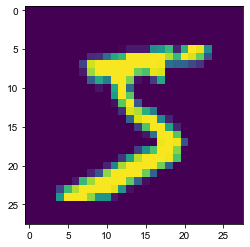

In [19]:
plt.imshow(X_train[0])
print(f'Class {y_train[0]}')

In [13]:
def preprocess(images): # for numpy arrays
    images = images.astype('float32') 
    images = images/255.0 
    images = images.reshape(-1,28,28,1) 
    return images

In [14]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)

#### Model

In [15]:
model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, #kernal_size可以简写成3
                  padding="same", activation='relu', 
                  input_shape=(28,28,1), #keras默认忽略第一个维度，即m/batch_size，所以为None
                  kernel_regularizer='l2'), #kernel_regularizer=regularizers.l2(l2=0.01)
    layers.BatchNormalization(axis=-1),
    layers.MaxPooling2D(pool_size=(2,2), # 高宽各减半的池化层，可以简写为2
                        strides=2), # strides默认和pool_size一样
    layers.Conv2D(64, 3, 1, activation='relu'), 
    layers.MaxPooling2D(2, 2),
    layers.Flatten(), # 打平层，方便全连接层处理
    layers.Dense(128, activation='relu'), # 全连接层，128个节点
    layers.Dense(10, activation='softmax'), 
])

#model.build(input_shape=(28, 28, 1)) #单独设置input，或者在第一层Conv2D输入input

In [79]:
model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [17]:
model.compile(optimizer='sgd', #keras.optimizers.SGD(learning_rate=0.01)
              loss="sparse_categorical_crossentropy", #当labels为数字时使用，若为one-hot使用categorical_crossentropy
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, validation_split=0.1) #默认32samples/batch

Epoch 1/5
1688/1688 [==============================] - 116s 68ms/step - loss: 0.1706 - accuracy: 0.9544 - val_loss: 0.0753 - val_accuracy: 0.9835
Epoch 2/5
1688/1688 [==============================] - 115s 68ms/step - loss: 0.0705 - accuracy: 0.9826 - val_loss: 0.0572 - val_accuracy: 0.9890
Epoch 3/5
1688/1688 [==============================] - 113s 67ms/step - loss: 0.0525 - accuracy: 0.9873 - val_loss: 0.0607 - val_accuracy: 0.9857
Epoch 4/5
1688/1688 [==============================] - 114s 67ms/step - loss: 0.0421 - accuracy: 0.9896 - val_loss: 0.0475 - val_accuracy: 0.9893
Epoch 5/5
1688/1688 [==============================] - 118s 70ms/step - loss: 0.0356 - accuracy: 0.9911 - val_loss: 0.0466 - val_accuracy: 0.9895


#### Visualize

通过抽取每一层的output可以可视化地看到CNN提取Features的特性，这个功能常用于Transfer learning提取pretrained model某些层的结果用于自己的模型，如Facenet、NST等

In [80]:
model.inputs # 等同于model.input直接输出，没有列表

[<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_5_input')>]

In [ ]:
model.outputs # 只输出最后一层的output，等同于model.output，没有列表

In [81]:
model.layers

In [82]:
for layer in model.layers:
    print(f'{layer.name}: {layer.output}\n') #单独取每一层的output

conv2d_5: KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 64), dtype=tf.float32, name=None), name='conv2d_5/Relu:0', description="created by layer 'conv2d_5'")

batch_normalization: KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 64), dtype=tf.float32, name=None), name='batch_normalization/FusedBatchNormV3:0', description="created by layer 'batch_normalization'")

max_pooling2d_5: KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 64), dtype=tf.float32, name=None), name='max_pooling2d_5/MaxPool:0', description="created by layer 'max_pooling2d_5'")

conv2d_6: KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 64), dtype=tf.float32, name=None), name='conv2d_6/Relu:0', description="created by layer 'conv2d_6'")

max_pooling2d_6: KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 64), dtype=tf.float32, name=None), name='max_pooling2d_6/MaxPool:0', description="created by layer 'max_pooling2d_6'")

flatten_1: KerasTensor(type_spec=TensorSpec(shape=(None, 2304), dtype=tf.f

In [84]:
model.get_layer('conv2d_5').output #相等于model.layers[0].output

<KerasTensor: shape=(None, 28, 28, 64) dtype=float32 (created by layer 'conv2d_5')>

<a id='layer'></a>
Visualize different filters throughout the conv layers to check what kind of features the convnet has learned. Let's define a new Model that will take an image as input, and will output **intermediate representations** for all layers.

In [85]:
# Generate a model that outputs all layers
IMAGE = [0, 100, 200] # Compare different photos
FILTER_NUMBER = 60 # Specific filter out of 64 filters in all Conv layers
layer_outputs = [layer.output for layer in model.layers] 
visual_model = keras.Model(inputs = model.input, outputs = layer_outputs) 

Text(0, 0.5, 'Image 0\nPredict:7, Actual:7')

Text(0, 0.5, 'Image 100\nPredict:6, Actual:6')

Text(0, 0.5, 'Image 200\nPredict:3, Actual:3')

Text(0.5, 0.98, 'The 60th Filter Visualization for Layer 1-5')

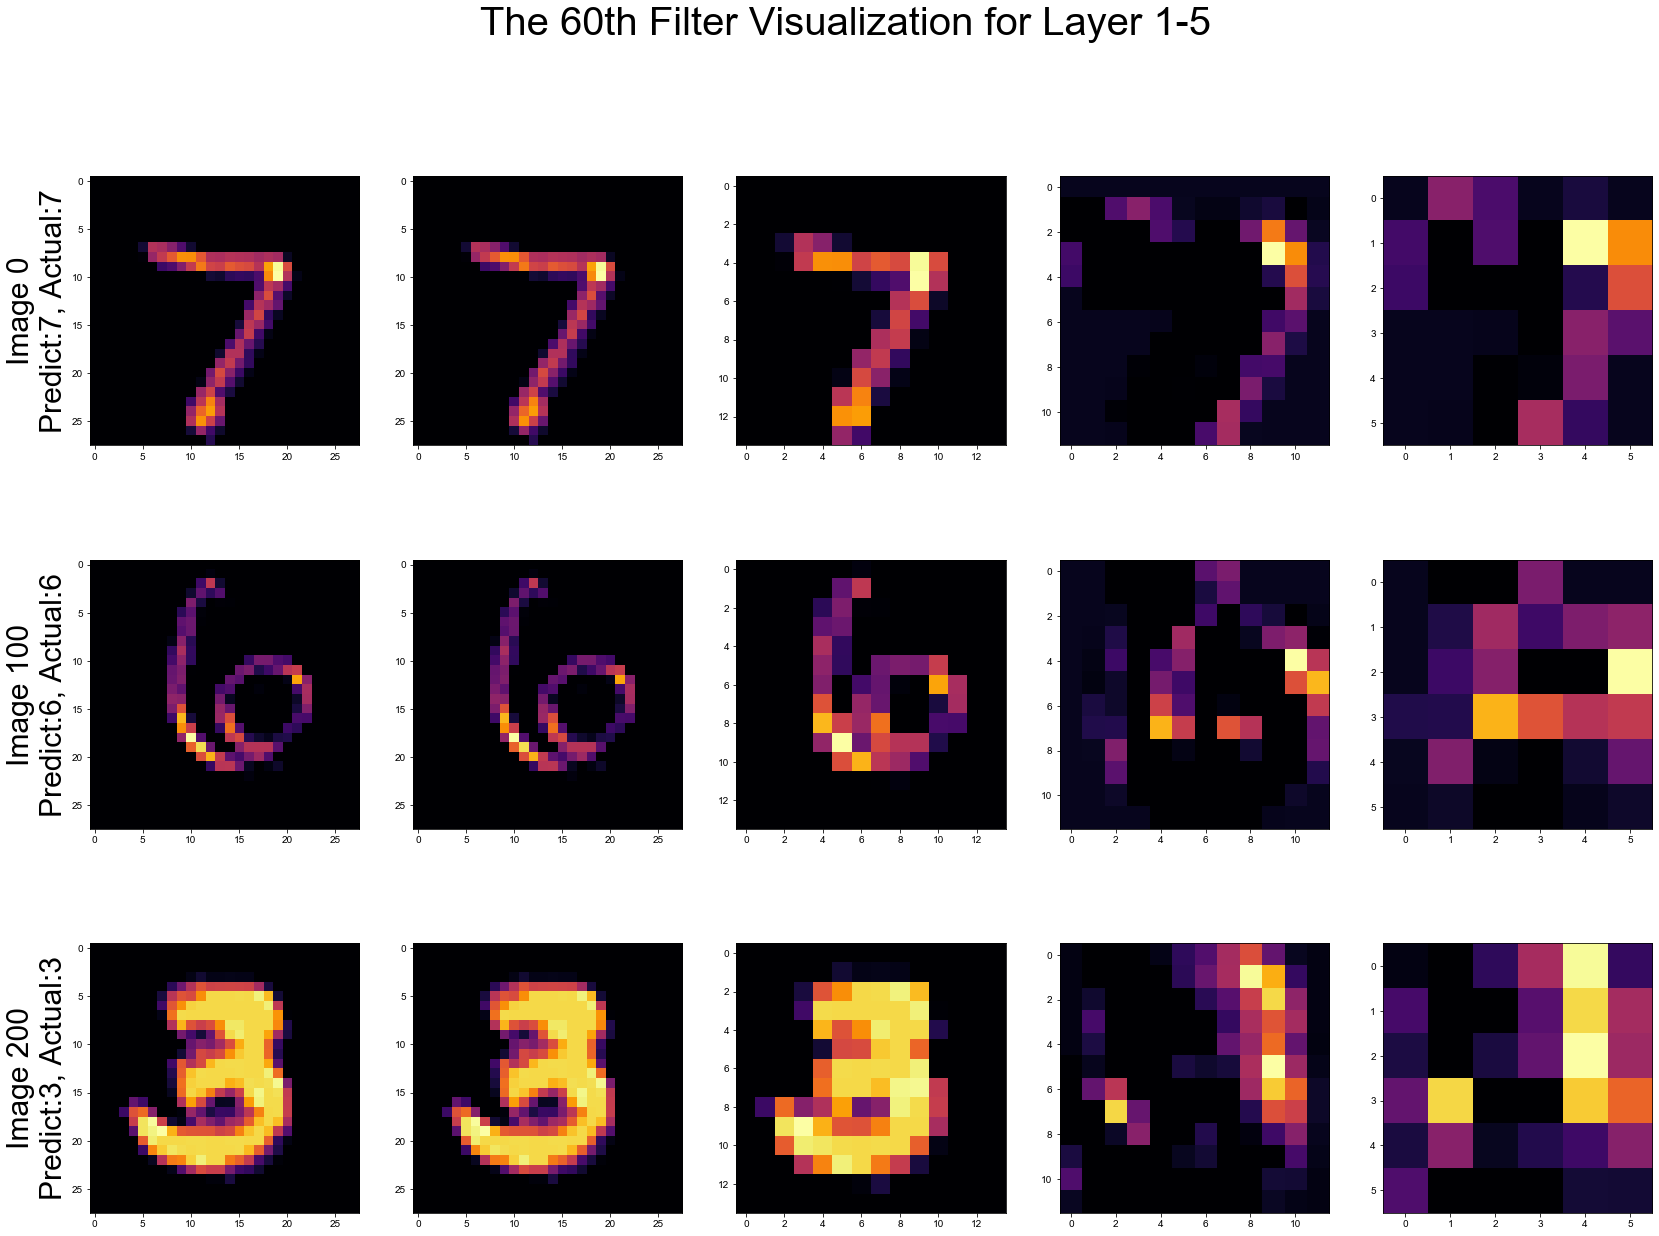

In [86]:
# Visualize one filter in all conv layers
f, ax = plt.subplots(3,5, figsize=(28,20)) #对比三张图片，前5层conv layer的output
for i in range(0,3):
    for l in range(0,5):
        outputs = visual_model.predict(x_test[IMAGE[i]].reshape(1, 28, 28, 1)) #reshape把h,w,c图片变为m,h,w,c的input
        ax[i,l].imshow(outputs[l][0, : , :, FILTER_NUMBER], cmap='inferno') #imshow图片要变回h,w,c图片
        ax[i,l].grid(False)
    ax[i,0].set_ylabel(f'Image {IMAGE[i]}\nPredict:{np.argmax(outputs[-1])}, Actual:{y_test[IMAGE[i]]}', fontsize=30)
plt.suptitle(f'The {FILTER_NUMBER}th Filter Visualization for Layer 1-5', fontsize=40)

#### Evaluation

In [87]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 6s 18ms/step - loss: 0.0410 - accuracy: 0.9899


[0.04099562019109726, 0.9898999929428101]

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.title(string.capitalize())
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

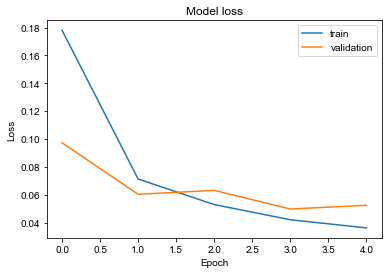

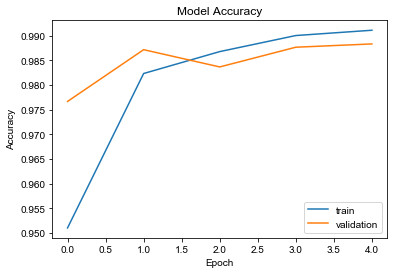

In [88]:
log = pd.DataFrame(history.history)

loss = log[['loss','val_loss']].copy()
loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
loss.plot(title='Model loss').set(xlabel='Epoch',ylabel='Loss') 

acc= log[['accuracy','val_accuracy']].copy()
acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
acc.plot(title='Model Accuracy').set(xlabel='Epoch',ylabel='Accuracy')

#### Prediction

In [8]:
plt.imshow(x_test[0])
y_pred = model.predict(x_test)
plt.title(f'Predict: Class {np.argmax(y_pred[0])}, Actual: Class {y_test[0]}')

array([[2.16945284e-09, 1.30808555e-08, 4.05047740e-06, ...,
        9.99994993e-01, 1.81006250e-08, 7.47334727e-09],
       [6.34766753e-11, 4.26162075e-08, 1.00000000e+00, ...,
        8.98281219e-14, 3.60347863e-09, 2.37691472e-14],
       [1.30741626e-07, 9.99656320e-01, 3.19831270e-05, ...,
        1.13023278e-04, 1.49140142e-05, 6.52098890e-08],
       ...,
       [3.52960147e-13, 8.40308170e-11, 7.97992450e-14, ...,
        1.77148785e-09, 1.58005445e-12, 6.86232852e-07],
       [1.72493998e-07, 7.37036376e-10, 1.66379699e-09, ...,
        8.94434482e-09, 1.79271179e-03, 4.69548012e-10],
       [9.76720571e-07, 3.01737038e-11, 6.69931126e-07, ...,
        2.87627622e-14, 2.56172039e-09, 2.98645206e-11]], dtype=float32)